In [58]:
!pwd

/Users/ariellubonja/prog/drugs-embedding


In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch as torch
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

In [60]:
basic_drugs = ['ibuprofen', 'paracetamol', 'acetaminophen', 'irbesartan', 'valsartan', 'nifedipine', 'lidocaine', 'nifedipine+lidocaine']

In [61]:
import numpy as np
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine

mat = np.zeros([8, 768])
i=0
for drug in basic_drugs:
    inputs = tokenizer.encode(drug, return_tensors="pt")
    with torch.no_grad():
        last_hidden_states = model(inputs)[0] # Models outputs are now tuples
        last_hidden_states = last_hidden_states.mean(1)
        mat[i,:] = last_hidden_states
        i+=1
        
dist_out = 1-pairwise_distances(mat, metric="cosine")
dist_out

array([[1.        , 0.86294214, 0.85267171, 0.84820416, 0.81653751,
        0.85546236, 0.76596559, 0.86508643],
       [0.86294214, 1.        , 0.92513819, 0.83288752, 0.83376242,
        0.86908405, 0.8204691 , 0.87903039],
       [0.85267171, 0.92513819, 1.        , 0.80286387, 0.80868284,
        0.85361933, 0.82269752, 0.8723122 ],
       [0.84820416, 0.83288752, 0.80286387, 1.        , 0.96690074,
        0.86654798, 0.74402636, 0.86668083],
       [0.81653751, 0.83376242, 0.80868284, 0.96690074, 1.        ,
        0.8553561 , 0.74542866, 0.85410051],
       [0.85546236, 0.86908405, 0.85361933, 0.86654798, 0.8553561 ,
        1.        , 0.7782484 , 0.94775204],
       [0.76596559, 0.8204691 , 0.82269752, 0.74402636, 0.74542866,
        0.7782484 , 1.        , 0.84822918],
       [0.86508643, 0.87903039, 0.8723122 , 0.86668083, 0.85410051,
        0.94775204, 0.84822918, 1.        ]])

In [1]:
# Read the list of molecules
import pandas as pd
molecules = pd.read_excel("data/gain-synonyms-list.xlsx")

In [2]:
molecules_list = list(molecules['Gain'].str.lower())
# selected_molecules = [m.split(" ")[-1] for m in molecules_list[0:7000] if (("+" not in m) and 

selected_molecules = [m for m in molecules_list[0:7000] if (("+" not in m) and 
                      (m.endswith("olol") or 
                      m.endswith('cillin') or 
                      m.endswith('sartan') or 
                      m.endswith('mycin') or 
                      m.endswith('vir') or 
                      m.endswith('parin') or
                      m.endswith('mab') or 
                      m.endswith('lamide') or
                      m.endswith('caine') or
                      m.endswith('bital') or
                      m.endswith('afil') or
                      m.endswith('asone') or
                      m.endswith('profen') or 
                      m.endswith('statin') or
                      m.endswith('tinib')))]

In [3]:
selected_molecules = list(set(selected_molecules))
len(selected_molecules)

337

In [4]:
selected_molecules[:10]

['j05af10 entecavir',
 'entrectinib',
 'l04aa45 filgotinib',
 'g04be08 tadalafil',
 's01ba01 dexamethasone',
 'lidocaine',
 'natalizumab',
 'j05aj04 cabotegravir',
 'esmolol',
 'c09ca06 candesartan']

In [66]:
#embeddings and cosines
mat = np.zeros([len(selected_molecules), 768])
i=0
print("Computing embeddings...")
for drug in selected_molecules:
    inputs = tokenizer.encode(drug, return_tensors="pt")
    with torch.no_grad():
        last_hidden_states = model(inputs)[0] # Models outputs are now tuples
        last_hidden_states = last_hidden_states.mean(1)
        mat[i,:] = last_hidden_states
        i+=1
print("Computing cosines...")
dist_out = 1-pairwise_distances(mat, metric="cosine")
dist_out

Computing embeddings...
Computing cosines...


array([[1.        , 0.86633927, 0.93455955, ..., 0.87701651, 0.92625845,
        0.90167808],
       [0.86633927, 1.        , 0.87708322, ..., 0.87340261, 0.85912274,
        0.89560609],
       [0.93455955, 0.87708322, 1.        , ..., 0.85643659, 0.88483231,
        0.88429627],
       ...,
       [0.87701651, 0.87340261, 0.85643659, ..., 1.        , 0.88795311,
        0.92344166],
       [0.92625845, 0.85912274, 0.88483231, ..., 0.88795311, 1.        ,
        0.89520139],
       [0.90167808, 0.89560609, 0.88429627, ..., 0.92344166, 0.89520139,
        1.        ]])

In [67]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
Z = linkage(mat, metric = 'cosine', method = 'single')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


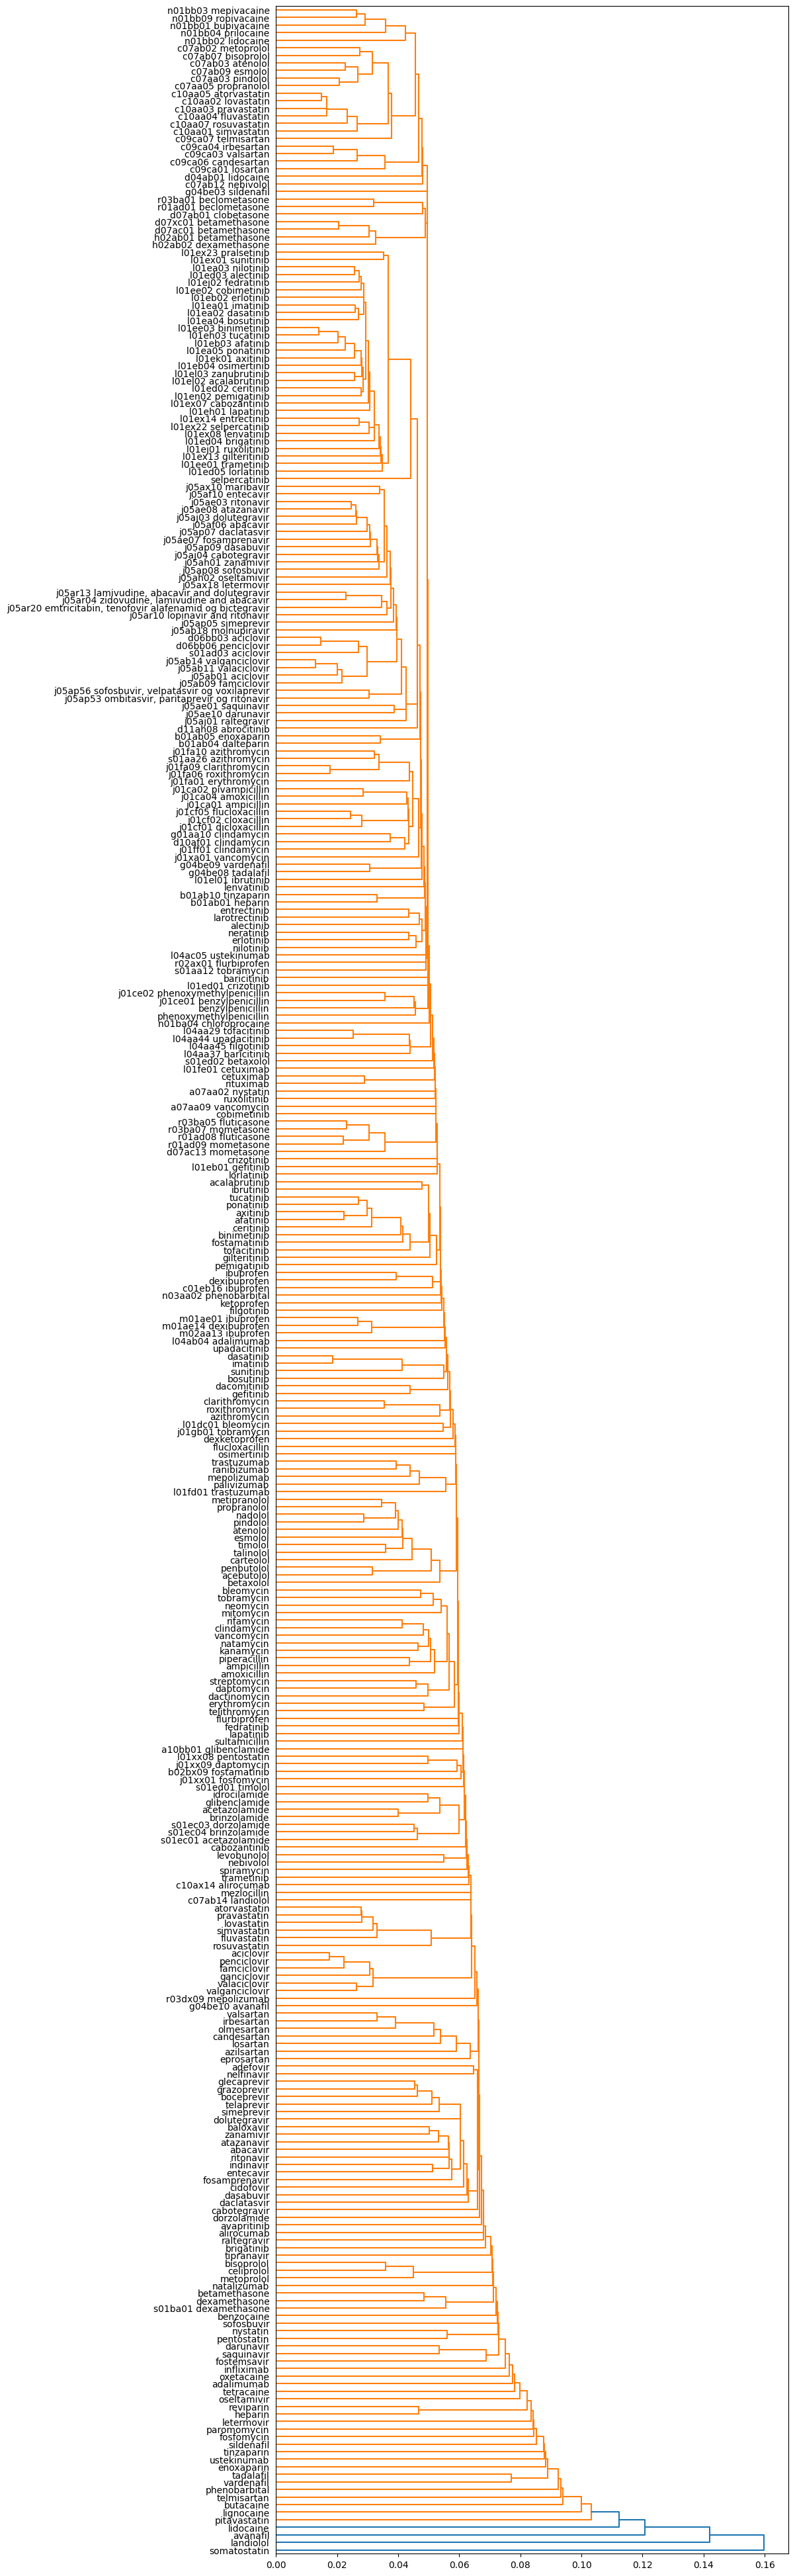

In [68]:
fig = plt.figure(figsize=(10, 50))
# dn = dendrogram(Z)
dendrogram(
            Z,
            orientation='right',
            labels=selected_molecules,
#             distance_sort='descending',
#             show_leaf_counts=False
          )
plt.yticks(size = 10)
plt.xticks(size = 10)
plt.show()

In [69]:
from sklearn.cluster import AgglomerativeClustering
hierarchical_cluster = AgglomerativeClustering(distance_threshold=0.06,
                                               n_clusters = None,
                                               affinity='cosine', 
                                               linkage='single',
                                               compute_distances = True)
labels = hierarchical_cluster.fit_predict(mat)


/Users/ariellubonja/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [70]:
labels

array([ 0,  5,  0, 66, 55, 50,  0,  0,  0,  0,  0,  4,  0,  0, 49, 13,  0,
        0, 11,  0,  0, 57,  0,  0, 43,  0,  0,  0,  0,  0,  0,  0, 61,  0,
        0,  7, 34,  0,  0,  0,  0,  0,  0,  7,  0, 45,  0,  2,  2,  0, 44,
        0,  0,  0,  2, 60, 13,  0,  4,  0,  0,  0, 11,  3, 39,  0,  0, 37,
       54,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 64,  0,  0,  0,  0,
        0, 41,  0,  0,  0,  0, 63,  0,  0,  4,  0, 62,  0, 56,  0, 35,  0,
        0,  0,  4,  0,  0,  0,  0,  0,  0,  1,  0, 38, 58,  0,  0,  0,  0,
        0,  0,  0, 28, 46,  0,  0,  0, 21,  0,  0,  0,  5, 27,  0,  0,  3,
        0,  0, 28,  0,  0,  0,  0,  2,  0,  0,  2,  0,  0,  0,  0, 47,  0,
       33, 13, 16,  0,  0,  0,  0,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,
       14,  0, 11,  0, 11,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,
       59,  9,  0,  0, 24,  0,  4,  9, 22,  0,  3,  0,  0,  0,  6,  0, 36,
       14,  0, 10,  0,  0, 29,  0,  0,  0, 17, 65,  3,  0, 10,  0,  0,  0,
       42,  0,  0, 20, 48

In [71]:
for i in set(labels):
    print([selected_molecules[j] for j in range(len(selected_molecules)) if labels[j]==i])
    # print("\n")

['l01en02 pemigatinib', 'pemigatinib', 'j01ca04 amoxicillin', 'l01ed03 alectinib', 'j05ar10 lopinavir and ritonavir', 'palivizumab', 'roxithromycin', 'n01ba04 chloroprocaine', 'c07aa05 propranolol', 'ampicillin', 'n01bb01 bupivacaine', 'osimertinib', 'l01ex01 sunitinib', 'j01cf02 cloxacillin', 'tobramycin', 'n03aa02 phenobarbital', 'b01ab01 heparin', 'mepolizumab', 'j01cf05 flucloxacillin', 'l01eh03 tucatinib', 'l01ex23 pralsetinib', 'c09ca03 valsartan', 's01ed02 betaxolol', 'lenvatinib', 'c07ab09 esmolol', 'j01ca01 ampicillin', 'lorlatinib', 'dexibuprofen', 'l01eb01 gefitinib', 'j05ab11 valaciclovir', 'j05ah02 oseltamivir', 'flucloxacillin', 'c10aa04 fluvastatin', 'nilotinib', 'n01bb02 lidocaine', 'l01el02 acalabrutinib', 'l04aa45 filgotinib', 'd04ab01 lidocaine', 'j05ae08 atazanavir', 'c09ca06 candesartan', 'd11ah08 abrocitinib', 'esmolol', 'j01fa06 roxithromycin', 'd06bb06 penciclovir', 'h02ab02 dexamethasone', 'baricitinib', 'dexketoprofen', 'h02ab01 betamethasone', 'j05ar04 zidovu

In [73]:
from sklearn.decomposition import PCA
 
pca = PCA(n_components = 20)
 
mat_small = pca.fit_transform(mat)

Y = linkage(mat_small, metric = 'cosine', method = 'single', optimal_ordering=True)

In [75]:
mat_small.shape

(337, 20)

In [76]:
Y.shape

(336, 4)

In [74]:
Y[:10]

array([[7.00000000e+01, 2.38000000e+02, 2.08655463e-02, 2.00000000e+00],
       [1.30000000e+01, 1.24000000e+02, 2.38668097e-02, 2.00000000e+00],
       [2.17000000e+02, 2.70000000e+02, 2.57155408e-02, 2.00000000e+00],
       [3.24000000e+02, 4.20000000e+01, 3.18278401e-02, 2.00000000e+00],
       [3.10000000e+01, 6.10000000e+01, 3.42215285e-02, 2.00000000e+00],
       [1.50000000e+02, 9.00000000e+01, 3.56454383e-02, 2.00000000e+00],
       [2.49000000e+02, 3.41000000e+02, 3.69041460e-02, 3.00000000e+00],
       [1.42000000e+02, 2.45000000e+02, 3.88707663e-02, 2.00000000e+00],
       [3.39000000e+02, 2.50000000e+02, 3.97180103e-02, 3.00000000e+00],
       [1.09000000e+02, 1.92000000e+02, 3.99937198e-02, 2.00000000e+00]])

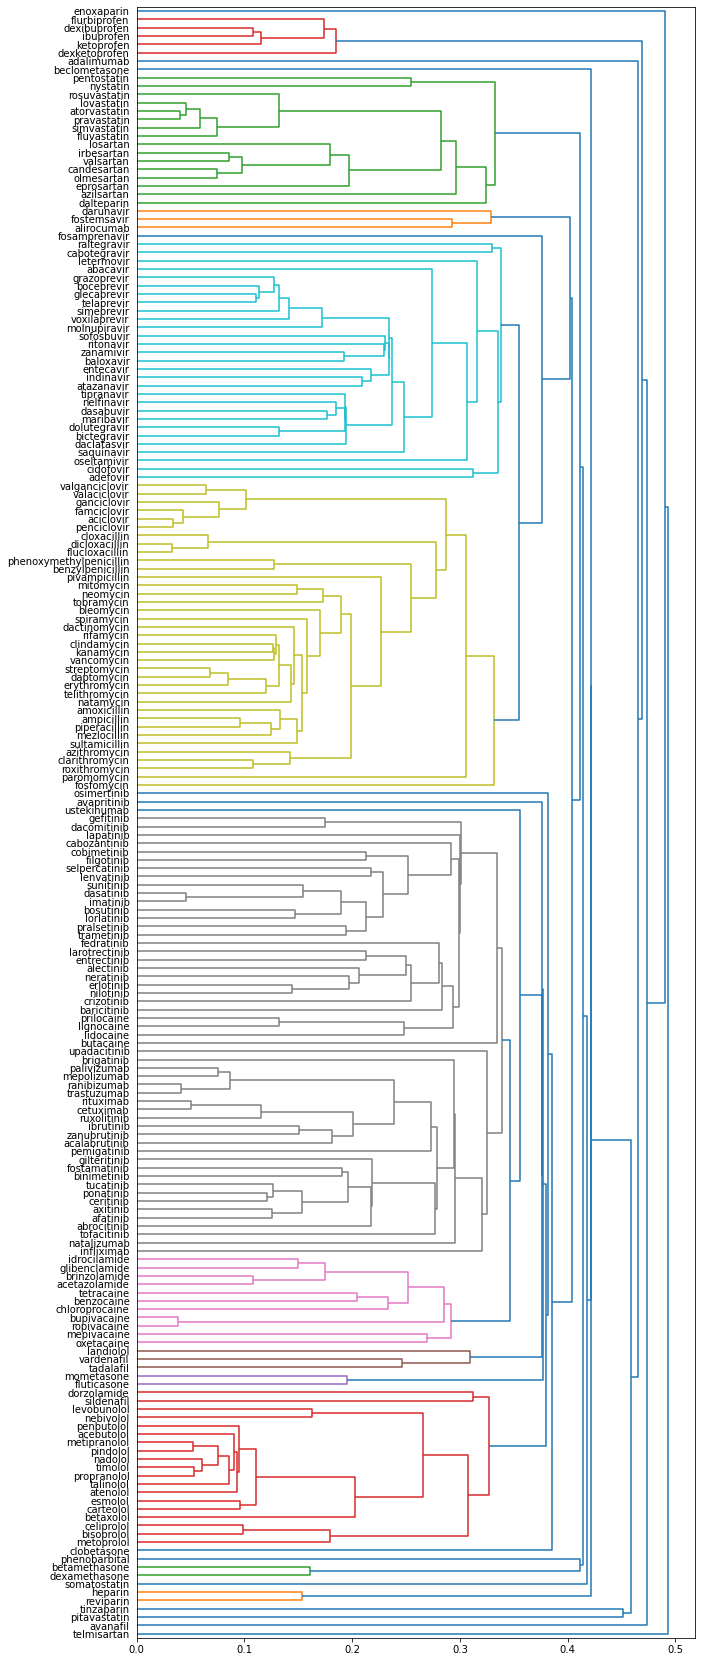

In [145]:
fig = plt.figure(figsize=(10, 30))
# dn = dendrogram(Z)
dendrogram(
            Y,
            orientation='right',
            labels=selected_molecules
#             distance_sort='descending',
#             show_leaf_counts=False
          )
plt.yticks(size = 10)
plt.xticks(size = 10)
plt.show()

# LLM embeddings

1. Llama
2. Saudi thing (Falcon?)

# TODO Use Drug Class from Drugs.com as ground truth

In [5]:
# https://python.langchain.com/docs/modules/data_connection/text_embedding/integrations/llamacpp

from langchain.embeddings import LlamaCppEmbeddings
import numpy as np

In [19]:
# I got GGML from here https://huggingface.co/Pi3141/alpaca-native-7B-ggml/tree/397e872bf4c83f4c642317a5bf65ce84a105786e
# Need llama-cpp-python=0.1.48 for this to work
llama = LlamaCppEmbeddings(model_path="models/ggml-model-q4_0.bin")

llama.cpp: loading model from models/ggml-model-q4_0.bin
llama.cpp: can't use mmap because tensors are not aligned; convert to new format to avoid this
llama_model_load_internal: format     = 'ggml' (old version with low tokenizer quality and no mmap support)
llama_model_load_internal: n_vocab    = 32000
llama_model_load_internal: n_ctx      = 512
llama_model_load_internal: n_embd     = 4096
llama_model_load_internal: n_mult     = 256
llama_model_load_internal: n_head     = 32
llama_model_load_internal: n_layer    = 32
llama_model_load_internal: n_rot      = 128
llama_model_load_internal: ftype      = 2 (mostly Q4_0)
llama_model_load_internal: n_ff       = 11008
llama_model_load_internal: n_parts    = 1
llama_model_load_internal: model size = 7B
llama_model_load_internal: ggml ctx size = 4113748.20 KB
llama_model_load_internal: mem required  = 5809.33 MB (+ 2052.00 MB per state)
...................................................................................................
.
AVX = 

In [ ]:
llama_embeddings = []

for drug in selected_molecules:
    llama_embeddings.append(np.array(llama.embed_query(text)))

llama_embeddings = np.array(llama_embeddings)

In [21]:
llama_embeddings.shape

(337, 4096)

In [26]:
df_embeddings = pd.DataFrame(llama_embeddings, index=selected_molecules)
df_embeddings

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
j05af10 entecavir,3.030608,0.668737,1.2298,-6.182161,-0.812407,1.275752,0.430807,1.837162,-0.249098,1.199062,...,0.526793,0.69801,0.94362,-2.227502,1.127113,-2.115299,2.002693,-1.047605,-0.305849,2.522237
entrectinib,3.030608,0.668737,1.2298,-6.182161,-0.812407,1.275752,0.430807,1.837162,-0.249098,1.199062,...,0.526793,0.69801,0.94362,-2.227502,1.127113,-2.115299,2.002693,-1.047605,-0.305849,2.522237
l04aa45 filgotinib,3.030608,0.668737,1.2298,-6.182161,-0.812407,1.275752,0.430807,1.837162,-0.249098,1.199062,...,0.526793,0.69801,0.94362,-2.227502,1.127113,-2.115299,2.002693,-1.047605,-0.305849,2.522237
g04be08 tadalafil,3.030608,0.668737,1.2298,-6.182161,-0.812407,1.275752,0.430807,1.837162,-0.249098,1.199062,...,0.526793,0.69801,0.94362,-2.227502,1.127113,-2.115299,2.002693,-1.047605,-0.305849,2.522237
s01ba01 dexamethasone,3.030608,0.668737,1.2298,-6.182161,-0.812407,1.275752,0.430807,1.837162,-0.249098,1.199062,...,0.526793,0.69801,0.94362,-2.227502,1.127113,-2.115299,2.002693,-1.047605,-0.305849,2.522237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
oseltamivir,3.030608,0.668737,1.2298,-6.182161,-0.812407,1.275752,0.430807,1.837162,-0.249098,1.199062,...,0.526793,0.69801,0.94362,-2.227502,1.127113,-2.115299,2.002693,-1.047605,-0.305849,2.522237
dolutegravir,3.030608,0.668737,1.2298,-6.182161,-0.812407,1.275752,0.430807,1.837162,-0.249098,1.199062,...,0.526793,0.69801,0.94362,-2.227502,1.127113,-2.115299,2.002693,-1.047605,-0.305849,2.522237
dexketoprofen,3.030608,0.668737,1.2298,-6.182161,-0.812407,1.275752,0.430807,1.837162,-0.249098,1.199062,...,0.526793,0.69801,0.94362,-2.227502,1.127113,-2.115299,2.002693,-1.047605,-0.305849,2.522237
l01ex14 entrectinib,3.030608,0.668737,1.2298,-6.182161,-0.812407,1.275752,0.430807,1.837162,-0.249098,1.199062,...,0.526793,0.69801,0.94362,-2.227502,1.127113,-2.115299,2.002693,-1.047605,-0.305849,2.522237


In [33]:
df_embeddings.to_csv("outputs/llama-embeddings.csv", index_label="Drug Name")

In [36]:
pd.read_csv("outputs/llama-embeddings.csv", index_col="Drug Name")

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
Drug Name,,,,,,,,,,,,,,,,,,,,,
j05af10 entecavir,3.030608,0.668737,1.2298,-6.182161,-0.812407,1.275752,0.430807,1.837162,-0.249098,1.199062,...,0.526793,0.69801,0.94362,-2.227502,1.127113,-2.115299,2.002693,-1.047605,-0.305849,2.522237
entrectinib,3.030608,0.668737,1.2298,-6.182161,-0.812407,1.275752,0.430807,1.837162,-0.249098,1.199062,...,0.526793,0.69801,0.94362,-2.227502,1.127113,-2.115299,2.002693,-1.047605,-0.305849,2.522237
l04aa45 filgotinib,3.030608,0.668737,1.2298,-6.182161,-0.812407,1.275752,0.430807,1.837162,-0.249098,1.199062,...,0.526793,0.69801,0.94362,-2.227502,1.127113,-2.115299,2.002693,-1.047605,-0.305849,2.522237
g04be08 tadalafil,3.030608,0.668737,1.2298,-6.182161,-0.812407,1.275752,0.430807,1.837162,-0.249098,1.199062,...,0.526793,0.69801,0.94362,-2.227502,1.127113,-2.115299,2.002693,-1.047605,-0.305849,2.522237
s01ba01 dexamethasone,3.030608,0.668737,1.2298,-6.182161,-0.812407,1.275752,0.430807,1.837162,-0.249098,1.199062,...,0.526793,0.69801,0.94362,-2.227502,1.127113,-2.115299,2.002693,-1.047605,-0.305849,2.522237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
oseltamivir,3.030608,0.668737,1.2298,-6.182161,-0.812407,1.275752,0.430807,1.837162,-0.249098,1.199062,...,0.526793,0.69801,0.94362,-2.227502,1.127113,-2.115299,2.002693,-1.047605,-0.305849,2.522237
dolutegravir,3.030608,0.668737,1.2298,-6.182161,-0.812407,1.275752,0.430807,1.837162,-0.249098,1.199062,...,0.526793,0.69801,0.94362,-2.227502,1.127113,-2.115299,2.002693,-1.047605,-0.305849,2.522237
dexketoprofen,3.030608,0.668737,1.2298,-6.182161,-0.812407,1.275752,0.430807,1.837162,-0.249098,1.199062,...,0.526793,0.69801,0.94362,-2.227502,1.127113,-2.115299,2.002693,-1.047605,-0.305849,2.522237


### Put all pairwise similarities in a 2D matrix

In [ ]:
%%capture # Doesn't show all the output of the cell - Llama spams a lot
all_pairwise_similarities = [{drug_name: db0.similarity_search_with_score(drug_name, k=len(selected_molecules))} for drug_name in selected_molecules]

In [122]:
a = db0.similarity_search_with_score(df.columns[0], k=len(selected_molecules))


llama_print_timings:        load time =   302.45 ms
llama_print_timings:      sample time =     0.00 ms /     1 runs   (    0.00 ms per run)
llama_print_timings: prompt eval time =   572.05 ms /    12 tokens (   47.67 ms per token)
llama_print_timings:        eval time =     0.00 ms /     1 runs   (    0.00 ms per run)
llama_print_timings:       total time =   577.88 ms


In [128]:
a[0]

(Document(page_content='l01en02 pemigatinib', metadata={}), 0.0)

In [131]:
a[0][0].page_content

'l01en02 pemigatinib'

In [132]:
a[0][1]

0.0

In [136]:
def extract_embd_document_name(similarities):
    return [(entry[0].page_content, entry[1]) for entry in similarities]

In [139]:
extract_embd_document_name(a)

[('l01en02 pemigatinib', 0.0),
 ('l01eb04 osimertinib', 1476.6711),
 ('l01ea04 bosutinib', 1609.8052),
 ('l01ee02 cobimetinib', 1635.5913),
 ('l01ej01 ruxolitinib', 1638.4725),
 ('l01ex22 selpercatinib', 1673.733),
 ('l01el02 acalabrutinib', 1791.154),
 ('l01ee03 binimetinib', 1875.6926),
 ('l01eh03 tucatinib', 1937.9738),
 ('l01ex23 pralsetinib', 1945.2805),
 ('l01ed01 crizotinib', 2004.0723),
 ('l01ek01 axitinib', 2040.5039),
 ('l04aa45 filgotinib', 2072.4604),
 ('l01ex13 gilteritinib', 2127.712),
 ('pemigatinib', 2146.2495),
 ('l01ex08 lenvatinib', 2148.959),
 ('l01ed02 ceritinib', 2206.61),
 ('l01eb01 gefitinib', 2208.075),
 ('l01ex14 entrectinib', 2221.9912),
 ('l01el01 ibrutinib', 2291.8513),
 ('erlotinib', 2315.413),
 ('fostamatinib', 2328.4436),
 ('entrectinib', 2349.0332),
 ('gilteritinib', 2437.0417),
 ('l04ac05 ustekinumab', 2459.065),
 ('imatinib', 2544.958),
 ('larotrectinib', 2545.2358),
 ('l01ed03 alectinib', 2546.1343),
 ('l01el03 zanubrutinib', 2557.45),
 ('d11ah08 abr

In [114]:
df.columns

Index(['l01en02 pemigatinib', 'saquinavir', 'pemigatinib', 'dolutegravir',
       'sofosbuvir', 'eprosartan', 'j01ca04 amoxicillin', 'l01ed03 alectinib',
       'j05ar10 lopinavir and ritonavir', 'palivizumab',
       ...
       'j05ap08 sofosbuvir', 'nadolol',
       'j05ap56 sofosbuvir, velpatasvir og voxilaprevir', 'pitavastatin',
       'c07ab02 metoprolol', 'c07ab14 landiolol', 'dorzolamide',
       'j01cf01 dicloxacillin', 'c10aa01 simvastatin', 'c01eb16 ibuprofen'],
      dtype='object', length=337)